In [1]:
import numpy as np

# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
N = 2  # 表示机器的二进制 (0, 1)
n = 3  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3], [2, 3, 1], [3, 1, 2]])

b = np.array([[0, 0], [1, 0], [0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 100
P = 30
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [2]:
#
# def pauli_z_term(index, num_qubits):
#     """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'Z'
#     return ''.join(paulis)  # 将列表转化为字符串
def pauli_z_term(indices, num_qubits):
    """生成 Pauli-Z 项"""
    z_str = ['I'] * num_qubits
    for idx in indices:
        z_str[idx] = 'Z'
    return ''.join(z_str)


def pauli_x_term(index, num_qubits):
    paulis = ['I'] * num_qubits
    paulis[index] = 'X'
    return ''.join(paulis)

In [3]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits) == 1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N - 1]

        target_qubit = qubits[N - 1:]

        n_controls = len(control_qubits)
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [4]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

\begin{align}\sum_{h=0}^{l} 2^{h} z_{h}\end{align}

In [5]:
from qiskit.quantum_info import Pauli, SparsePauliOp, PauliList

# 初始化 Pauli 字符串和系数
pauli_strings = []
coefficients = []

# 构建哈密顿量
for h in range(l):
    coef = - 2 ** h / 2  # 系数为 2^h
    z_term = ['I'] * num_qubits
    z_term[n * N + h] = 'Z'  # 第 n * N + h 位是 Z，其余是 I
    pauli_strings.append(''.join(z_term))
    coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian1 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian1)

哈密顿量:
SparsePauliOp(['IIIIIIZ'],
              coeffs=[-0.5+0.j])


\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [6]:
from itertools import combinations

# 初始化哈密顿量参数
pauli_strings = []
coefficients = []

# 遍历 j 和 i
for j in range(len(bw)):
    for i in range(n):
        # 枚举 k 的所有子集
        for subset_size in range(N + 1):  # 子集大小
            for subset in combinations(range(N), subset_size):
                # 计算子集 S 的系数
                coef = K1
                for k in subset:
                    coef *= (0.5 - b[j][k])  # 子集 S 中的项
                for k in range(N):
                    if k not in subset:
                        coef *= 0.5  # 非子集项的贡献

                # 生成对应的 Pauli-Z 项
                indices = [i * N + k for k in subset]  # 转为量子比特索引
                z_term = pauli_z_term(indices, num_qubits)

                # 添加到哈密顿量
                pauli_strings.append(z_term)
                coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian2 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian2)

哈密顿量:
SparsePauliOp(['IIIIIII', 'ZIIIIII', 'IZIIIII', 'ZZIIIII', 'IIIIIII', 'IIZIIII', 'IIIZIII', 'IIZZIII', 'IIIIIII', 'IIIIZII', 'IIIIIZI', 'IIIIZZI'],
              coeffs=[25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j,
 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j])


\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [7]:
# 初始化参数
pauli_strings = []
coefficients = []

# 第一部分：双重乘积项
for j in range(m):
    for i in range(n):
        for i_prime in range(n):
            coef = p[i, j] * p[i_prime, j] / (2 ** (2 * N))
            z_term = ['I'] * num_qubits
            for k in range(N):
                if b[j, k] == 1:
                    z_term[i * N + k] = 'Z'
                    z_term[i_prime * N + k] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)

# 第二部分：结合时间和二进制位
for j in range(m):
    for i in range(n):
        for h in range(l):
            coef = -2 * p[i, j] * (2 ** (h - 1)) / (2 ** N)
            z_term = ['I'] * num_qubits
            for k in range(N):
                if b[j, k] == 1:
                    z_term[i * N + k] = 'Z'
            z_term[n * N + h] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)

# 第三部分：纯二进制项
for h in range(l):
    for h_prime in range(l):
        coef = 2 ** (h - 1) * 2 ** (h_prime - 1)
        z_term = ['I'] * num_qubits
        if h == h_prime:
            z_term[n * N + h] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)
        else:
            z_term1 = z_term.copy()
            z_term2 = z_term.copy()
            z_term1[n * N + h] = 'Z'
            z_term2[n * N + h_prime] = 'Z'
            pauli_strings.append(''.join(z_term1))
            coefficients.append(-coef)
            pauli_strings.append(''.join(z_term2))
            coefficients.append(-coef)
            z_term1[n * N + h_prime] = 'Z'
            pauli_strings.append(''.join(z_term1))
            coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian3 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian3)

哈密顿量:
SparsePauliOp(['IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'ZIIIIII', 'ZIZIIII', 'ZIIIZII', 'ZIZIIII', 'IIZIIII', 'IIZIZII', 'ZIIIZII', 'IIZIZII', 'IIIIZII', 'IZIIIII', 'IZIZIII', 'IZIIIZI', 'IZIZIII', 'IIIZIII', 'IIIZIZI', 'IZIIIZI', 'IIIZIZI', 'IIIIIZI', 'IIIIIIZ', 'IIIIIIZ', 'IIIIIIZ', 'ZIIIIIZ', 'IIZIIIZ', 'IIIIZIZ', 'IZIIIIZ', 'IIIZIIZ', 'IIIIIZZ', 'IIIIIIZ'],
              coeffs=[ 0.0625+0.j,  0.125 +0.j,  0.1875+0.j,  0.125 +0.j,  0.25  +0.j,
  0.375 +0.j,  0.1875+0.j,  0.375 +0.j,  0.5625+0.j,  0.25  +0.j,
  0.375 +0.j,  0.125 +0.j,  0.375 +0.j,  0.5625+0.j,  0.1875+0.j,
  0.125 +0.j,  0.1875+0.j,  0.0625+0.j,  0.5625+0.j,  0.1875+0.j,
  0.375 +0.j,  0.1875+0.j,  0.0625+0.j,  0.125 +0.j,  0.375 +0.j,
  0.125 +0.j,  0.25  +0.j, -0.25  +0.j, -0.5   +0.j, -0.75  +0.j,
 -0.5   +0.j, -0.75  +0.j, -0.25  +0.j, -0.75  +0.j, -0.25  +0.j,
 -0.5   +0.j,  0.25  +0.j])


In [8]:
cost_hamiltonian = hamiltonian1 + hamiltonian2 + hamiltonian3

In [9]:
# 初始化数组
pauli_strings = []
coefficients = []
x_terms = []
z_terms = []
for i in range(num_qubits):
    coef = 1
    x_term = pauli_x_term(i, num_qubits)
    x_terms.append((coef, x_term))

# 提取所有的 Pauli 字符串和系数
pauli_strings = [term[1] for term in x_terms]
coefficients = [term[0] for term in x_terms]

# 转换为 SparsePauliOp
paulis = [Pauli(label) for label in pauli_strings]
mixer_hamiltonian = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

print(mixer_hamiltonian)

SparsePauliOp(['XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [10]:
def invert_counts(s):
    return s[::-1]  # 反转字符串 

In [11]:
from qiskit.opflow import PauliTrotterEvolution
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length = len(params)
    # cost_hamiltonian2 = PauliSumOp(cost_hamiltonian)
    # mixer_hamiltonian2 = PauliSumOp(mixer_hamiltonian)
    for ga, be in zip(gamma, beta):
        # 应用问题哈密顿量
        qc.append(PauliEvolutionGate(cost_hamiltonian, ga), list(range(num_qubits)))
        # 应用混合哈密顿量
        qc.append(PauliEvolutionGate(mixer_hamiltonian, be), list(range(num_qubits)))
        # 构建演化电路
        # evolution_cost = PauliTrotterEvolution().convert((ga * cost_hamiltonian2).exp_i())
        # evolution_circuit_cost = evolution_cost.to_circuit()
        # evolution_mixer = PauliTrotterEvolution().convert((be * mixer_hamiltonian2).exp_i())
        # evolution_circuit_mixer = evolution_mixer.to_circuit()
        # qc.compose(evolution_circuit_cost, inplace=True)
        # qc.compose(evolution_circuit_mixer, inplace=True)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(len(b)):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
                constant1 += p[i, j] * constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant) ** 2

        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts

C:\Users\李华宪\AppData\Local\Temp\ipykernel_6048\2866952332.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliTrotterEvolution


In [12]:
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [14]:
import time

# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, 2 * np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数


C:\Users\李华宪\AppData\Local\Temp\ipykernel_6048\2866952332.py:32: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第： 1 层   第 56 个参数
第

优化时间： 2079.2714438438416
Optimal parameters: [14.12773993  3.83524266  1.75690261 -0.75433339  0.70476189  5.44156402]
Optimal value: 262.5957999999996
Final expectation value: 262.5957999999996
Final measurement counts: {'1111111': 2280, '1111101': 1377, '1111011': 1062, '1110011': 777, '0111111': 505, '1111001': 470, '1111100': 444, '1001111': 396, '1110111': 340, '1101111': 290, '1011111': 262, '1001101': 154, '1000111': 112, '1000011': 101, '1110010': 87, '1001011': 82, '1101101': 81, '1100111': 61, '0110111': 58, '0111110': 56, '1111010': 53, '1011011': 51, '1011101': 51, '1010111': 45, '1111000': 44, '1101100': 36, '0101111': 36, '1010011': 36, '0011111': 33, '0111011': 32, '1111110': 32, '1110001': 31, '1110110': 29, '1001100': 29, '1011001': 24, '0111001': 24, '1000001': 23, '1001010': 23, '1001000': 19, '0001111': 18, '1000101': 17, '1001001': 17, '0111101': 15, '0001101': 15, '1110100': 14, '1000010': 13, '1101011': 12, '1100011': 11, '1110101': 11, '1101000': 11, '1110000': 

C:\Users\李华宪\AppData\Local\Temp\ipykernel_6048\2866952332.py:32: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


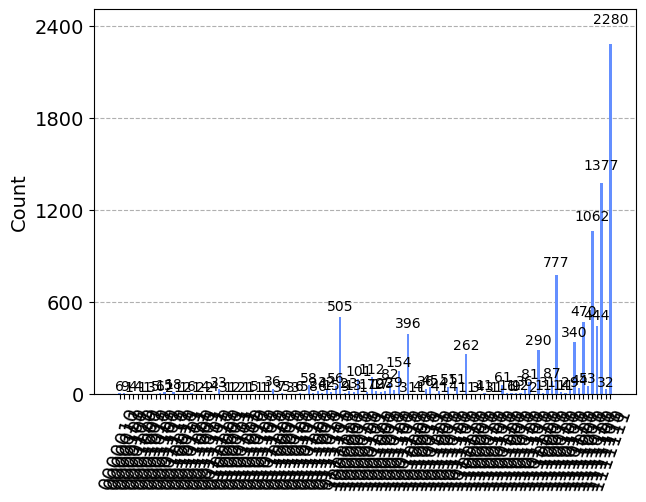

In [15]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [58]:
expectation = 0
bitstring = "0001101"
z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range(n):
        constant = 1
        for k in range(N):
            constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i, j] * constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

E = E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

5
0
0
